# Home Assignment 1.1: Wall Detection (2D LIDAR + Hough Transform)

Goal: detect straight wall lines in a 2D lidar point cloud using the Hough transform.

This notebook uses synthetic data with realistic effects:
- different room layouts (not only rectangular),
- inner walls with arbitrary angles,
- range noise,
- beam dropouts,
- random outliers.

## Why `data.txt` was not used

The previous `data.txt` file from Intel Lab contains sensor telemetry
(`temperature`, `humidity`, `light`, `voltage`) by `mote_id`, not 2D lidar scan points.

Because of that, it does not match HW 1.1 input requirements for wall detection from 2D lidar data.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(42)

plt.rcParams['figure.figsize'] = (11, 7)

## 1. Coordinate Transform Functions


In [ ]:
def transform_to_world(points_local, robot_pose):
    """
    Transform points from robot-local frame to world frame.

    Args:
        points_local: (N, 2)
        robot_pose: (x_robot, y_robot, theta_robot)

    Returns:
        points_world: (N, 2)
    """
    points_local = np.asarray(points_local, dtype=float)
    x_r, y_r, theta = robot_pose

    rot = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)],
    ])

    points_world = (rot @ points_local.T).T + np.array([x_r, y_r])
    return points_world


def transform_to_local(points_world, robot_pose):
    """Transform points from world frame to robot-local frame."""
    points_world = np.asarray(points_world, dtype=float)
    x_r, y_r, theta = robot_pose

    rot_inv = np.array([
        [ np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)],
    ])

    shifted = points_world - np.array([x_r, y_r])
    points_local = (rot_inv @ shifted.T).T
    return points_local


## 2. Synthetic Scene Setup

Define multiple room geometries, including non-rectangular layouts and angled inner walls

In [3]:
def polygon_to_segments(poly_points):
    """Convert a closed polygon into wall segments."""
    segs = []
    for i in range(len(poly_points)):
        x1, y1 = poly_points[i]
        x2, y2 = poly_points[(i + 1) % len(poly_points)]
        segs.append((x1, y1, x2, y2))
    return segs


def get_scenarios():
    scenarios = {}

    # Scenario 1: rectangular room + diagonal inner wall.
    outer1 = [(-6, -4), (6, -4), (6, 4), (-6, 4)]
    inner1 = [(-1.5, -4.0, 2.8, 1.2)]
    scenarios['rect_plus_diagonal'] = {
        'segments': polygon_to_segments(outer1) + inner1,
        'robot_pose': (0.0, -0.2, np.deg2rad(20.0)),
    }

    # Scenario 2: L-shaped room + slanted partition.
    outer2 = [(-6, -4), (2, -4), (2, -1), (6, -1), (6, 4), (-6, 4)]
    inner2 = [(-2.2, -0.4, 1.2, 2.6)]
    scenarios['l_shaped_room'] = {
        'segments': polygon_to_segments(outer2) + inner2,
        'robot_pose': (-0.8, 0.4, np.deg2rad(-15.0)),
    }

    # Scenario 3: irregular polygon + two inner angled walls.
    outer3 = [(-5.5, -3.2), (4.8, -4.2), (7.2, 0.6), (1.0, 5.0), (-6.4, 2.8)]
    inner3 = [(-1.0, -2.8, 3.2, 0.5), (2.4, 1.1, 5.5, 2.9)]
    scenarios['irregular_with_angles'] = {
        'segments': polygon_to_segments(outer3) + inner3,
        'robot_pose': (0.2, -0.7, np.deg2rad(35.0)),
    }

    return scenarios


scenarios = get_scenarios()
print('Scenarios:', list(scenarios.keys()))


Scenarios: ['rect_plus_diagonal', 'l_shaped_room', 'irregular_with_angles']


## 3. Noisy 2D Lidar Simulation

Each beam is ray-cast against wall segments, then inject realistic noise, outliers, and missing returns.


In [ ]:
def cross2d(a, b):
    """2D cross product (scalar z-component)."""
    return a[0] * b[1] - a[1] * b[0]


def ray_segment_intersection(ray_origin, ray_dir, seg_a, seg_b, eps=1e-9):
    """
    Return distance t along a ray to intersection with a segment.
    Return None if there is no valid intersection.
    """
    p = np.asarray(ray_origin, dtype=float)
    r = np.asarray(ray_dir, dtype=float)
    q = np.asarray(seg_a, dtype=float)
    s = np.asarray(seg_b, dtype=float) - q

    rxs = cross2d(r, s)
    if abs(rxs) < eps:
        return None

    qmp = q - p
    t = cross2d(qmp, s) / rxs
    u = cross2d(qmp, r) / rxs

    if t >= 0 and 0 <= u <= 1:
        return float(t)
    return None


def simulate_lidar_scan(
    segments,
    robot_pose,
    num_beams=900,
    fov_deg=270,
    range_min=0.08,
    range_max=18.0,
    range_noise_base=0.01,
    range_noise_scale=0.01,
    dropout_prob=0.05,
    outlier_prob=0.02,
    cartesian_jitter=0.015,
):
    """
    Simulate a noisy 2D lidar scan in robot-local frame.
    """
    x_r, y_r, theta_r = robot_pose
    origin = np.array([x_r, y_r], dtype=float)

    angles = np.linspace(-np.deg2rad(fov_deg) / 2, np.deg2rad(fov_deg) / 2, num_beams)
    ranges = np.full(num_beams, np.nan, dtype=float)

    for i, a_local in enumerate(angles):
        a_world = theta_r + a_local
        ray_dir = np.array([np.cos(a_world), np.sin(a_world)], dtype=float)

        best_t = None
        for x1, y1, x2, y2 in segments:
            t = ray_segment_intersection(origin, ray_dir, (x1, y1), (x2, y2))
            if t is None:
                continue
            if t < range_min or t > range_max:
                continue
            if (best_t is None) or (t < best_t):
                best_t = t

        if best_t is None:
            continue

        sigma = range_noise_base + range_noise_scale * best_t
        noisy_t = best_t + np.random.normal(0.0, sigma)
        noisy_t = np.clip(noisy_t, range_min, range_max)

        if np.random.rand() < outlier_prob:
            noisy_t = np.random.uniform(range_min, range_max)
        if np.random.rand() < dropout_prob:
            continue

        ranges[i] = noisy_t

    valid = ~np.isnan(ranges)
    valid_angles = angles[valid]
    valid_ranges = ranges[valid]

    points_local = np.column_stack([
        valid_ranges * np.cos(valid_angles),
        valid_ranges * np.sin(valid_angles),
    ])

    if len(points_local) > 0:
        points_local += np.random.normal(0.0, cartesian_jitter, size=points_local.shape)

    return points_local, valid_angles, valid_ranges


In [ ]:
def plot_scene_world(segments, robot_pose, points_world=None, title='Scene (world frame)'):
    fig, ax = plt.subplots(figsize=(9, 8))

    for x1, y1, x2, y2 in segments:
        ax.plot([x1, x2], [y1, y2], color='black', linewidth=2)

    x_r, y_r, theta = robot_pose
    ax.scatter(x_r, y_r, s=220, c='red', marker='*', label='robot', zorder=5)
    ax.arrow(x_r, y_r, 0.8 * np.cos(theta), 0.8 * np.sin(theta),
             head_width=0.18, head_length=0.28, color='red', zorder=5)

    if points_world is not None and len(points_world) > 0:
        ax.scatter(points_world[:, 0], points_world[:, 1],
                   s=8, c='royalblue', alpha=0.5, label='lidar points')

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(alpha=0.3)
    ax.axis('equal')
    ax.legend()
    plt.show()


def plot_scan_local(points_local, title='LIDAR points (robot frame)'):
    fig, ax = plt.subplots(figsize=(8, 8))

    ax.scatter(points_local[:, 0], points_local[:, 1], s=8, c='royalblue', alpha=0.6)
    ax.scatter(0, 0, s=220, c='red', marker='*', zorder=5)

    ax.set_title(title)
    ax.set_xlabel('x_local')
    ax.set_ylabel('y_local')
    ax.grid(alpha=0.3)
    ax.axis('equal')
    plt.show()


## 4. Hough Accumulator Construction

In [ ]:
def hough_transform(points, theta_step_deg=1.0, rho_step=0.05):
    """Build Hough accumulator for line parameters (theta, rho)."""
    points = np.asarray(points, dtype=float)
    if points.ndim != 2 or points.shape[1] != 2 or len(points) == 0:
        raise ValueError('points must have shape (N, 2), N > 0')

    thetas = np.deg2rad(np.arange(0.0, 180.0, theta_step_deg))
    max_rho = np.hypot(points[:, 0], points[:, 1]).max()
    rhos = np.arange(-max_rho, max_rho + rho_step, rho_step)

    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.int32)

    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    theta_idx = np.arange(len(thetas))

    for x, y in points:
        rho_vals = x * cos_t + y * sin_t
        rho_idx = np.round((rho_vals - rhos[0]) / rho_step).astype(int)
        valid = (rho_idx >= 0) & (rho_idx < len(rhos))
        np.add.at(accumulator, (rho_idx[valid], theta_idx[valid]), 1)

    return accumulator, thetas, rhos


## 5. Peak Detection in Hough Space


In [ ]:
def find_hough_peaks(accumulator, thetas, rhos,
                     n_peaks=12,
                     threshold_ratio=0.35,
                     nms_rho=8,
                     nms_theta=8):
    """
    Find dominant lines via iterative non-maximum suppression (NMS).
    """
    work = accumulator.copy()
    max_vote = int(work.max())
    threshold = max(1, int(threshold_ratio * max_vote))

    peaks = []
    for _ in range(n_peaks):
        flat_idx = int(np.argmax(work))
        rho_idx, theta_idx = np.unravel_index(flat_idx, work.shape)
        votes = int(work[rho_idx, theta_idx])

        if votes < threshold:
            break

        peaks.append((thetas[theta_idx], rhos[rho_idx], votes, theta_idx, rho_idx))

        r0 = max(0, rho_idx - nms_rho)
        r1 = min(work.shape[0], rho_idx + nms_rho + 1)
        t0 = max(0, theta_idx - nms_theta)
        t1 = min(work.shape[1], theta_idx + nms_theta + 1)
        work[r0:r1, t0:t1] = 0

    return peaks


## 6. Line Visualization

Detected lines are drawn over the lidar point cloud for visual validation.


In [ ]:
def draw_hough_line(ax, theta, rho, x_range, y_range, **kwargs):
    """Draw one line from Hough parameters on given axes."""
    x_min, x_max = x_range
    y_min, y_max = y_range

    if abs(np.sin(theta)) > 1e-6:
        xs = np.array([x_min, x_max], dtype=float)
        ys = (rho - xs * np.cos(theta)) / np.sin(theta)
        ax.plot(xs, ys, **kwargs)

    elif abs(np.cos(theta)) > 1e-6:
        x_const = rho / np.cos(theta)
        ax.plot([x_const, x_const], [y_min, y_max], **kwargs)


def plot_hough_space(accumulator, thetas, rhos, peaks=None, title='Hough accumulator'):
    fig, ax = plt.subplots(figsize=(11, 6))

    im = ax.imshow(
        accumulator,
        aspect='auto',
        cmap='hot',
        extent=[np.rad2deg(thetas[0]), np.rad2deg(thetas[-1]), rhos[-1], rhos[0]],
    )
    ax.set_xlabel('theta (deg)')
    ax.set_ylabel('rho')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, label='votes')

    if peaks:
        for theta, rho, votes, _, _ in peaks:
            ax.scatter(np.rad2deg(theta), rho, c='cyan', s=60, marker='x', linewidths=2)

    plt.show()


def plot_detected_lines(points_local, peaks, title='Detected walls over lidar points'):
    fig, ax = plt.subplots(figsize=(9, 8))

    ax.scatter(points_local[:, 0], points_local[:, 1], s=8, c='royalblue', alpha=0.55, label='lidar points')
    ax.scatter(0, 0, s=220, c='red', marker='*', zorder=5, label='robot')

    x_min, x_max = points_local[:, 0].min(), points_local[:, 0].max()
    y_min, y_max = points_local[:, 1].min(), points_local[:, 1].max()
    margin = 0.6
    x_range = (x_min - margin, x_max + margin)
    y_range = (y_min - margin, y_max + margin)

    colors = plt.cm.tab10(np.linspace(0, 1, max(1, len(peaks))))
    for i, (theta, rho, votes, _, _) in enumerate(peaks):
        draw_hough_line(
            ax, theta, rho, x_range, y_range,
            color=colors[i % len(colors)],
            linewidth=2,
            linestyle='-',
            label=f'line {i+1}: theta={np.rad2deg(theta):.1f} deg, rho={rho:.2f}, votes={votes}'
        )

    ax.set_title(title)
    ax.set_xlabel('x_local')
    ax.set_ylabel('y_local')
    ax.grid(alpha=0.3)
    ax.axis('equal')
    ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1.0), fontsize=8)
    plt.tight_layout()
    plt.show()


## 7. Run pipeline

Pipeline steps:
1. coordinate transform,
2. Hough accumulator,
3. peak extraction,
4. wall overlay on lidar points.


In [9]:
def detect_walls_hough(points_local,
                       theta_step_deg=1.0,
                       rho_step=0.05,
                       n_peaks=12,
                       threshold_ratio=0.35,
                       nms_rho=8,
                       nms_theta=8):
    # Step 1: build Hough accumulator.
    accumulator, thetas, rhos = hough_transform(
        points_local,
        theta_step_deg=theta_step_deg,
        rho_step=rho_step,
    )

    # Step 2: detect prominent peaks (candidate walls).
    peaks = find_hough_peaks(
        accumulator,
        thetas,
        rhos,
        n_peaks=n_peaks,
        threshold_ratio=threshold_ratio,
        nms_rho=nms_rho,
        nms_theta=nms_theta,
    )

    return peaks, accumulator, thetas, rhos


Scenario: rect_plus_diagonal
Lidar points: 935
Beam coverage (valid): 93.5%


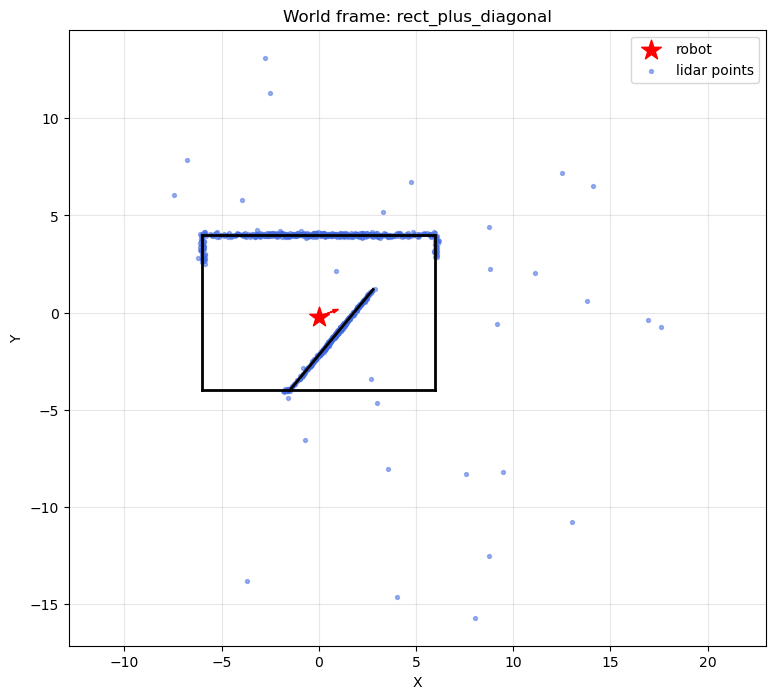

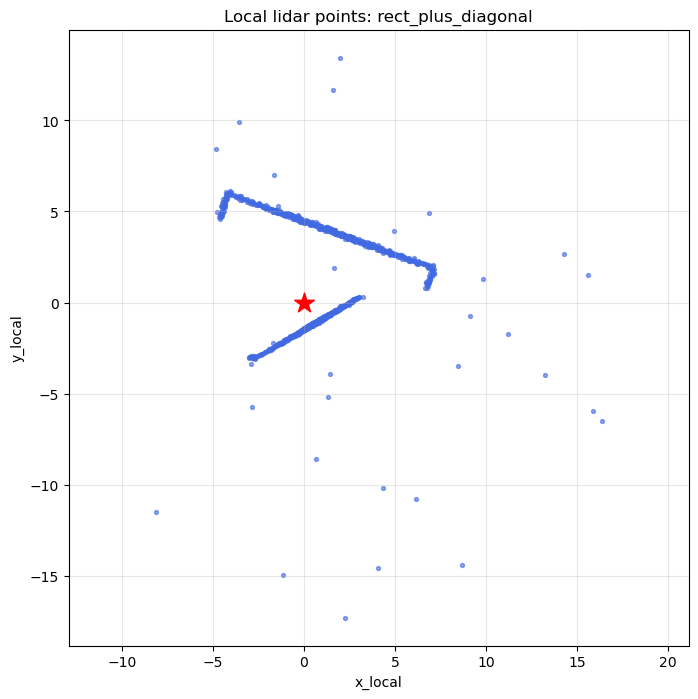

Detected lines: 2
 1. theta=120.00 deg | rho= -1.255 | votes=240
 2. theta= 70.00 deg | rho=  4.195 | votes=98


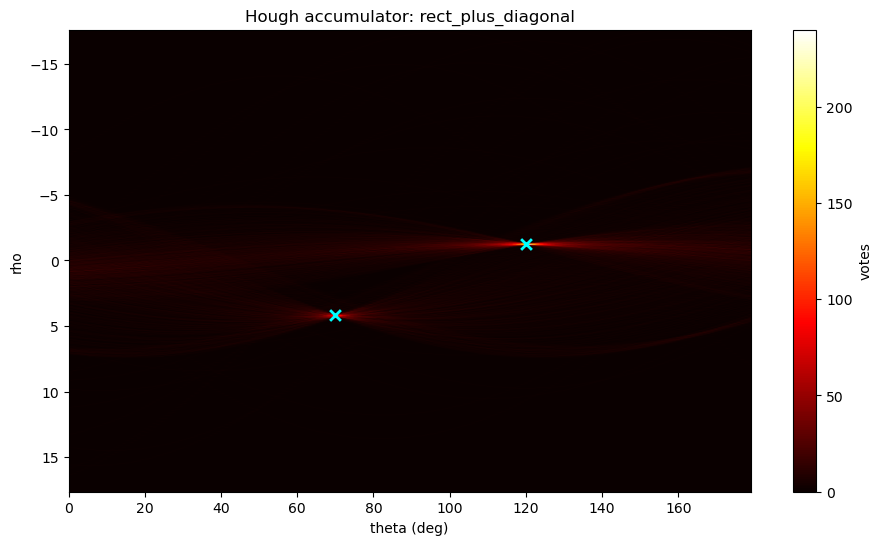

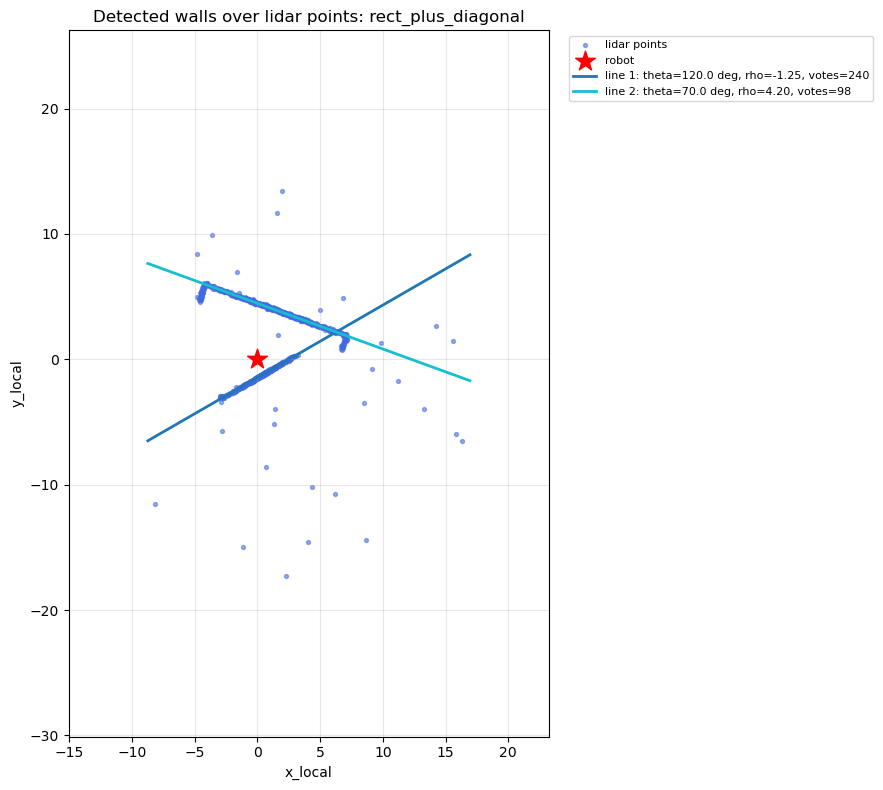

Scenario: l_shaped_room
Lidar points: 944
Beam coverage (valid): 94.4%


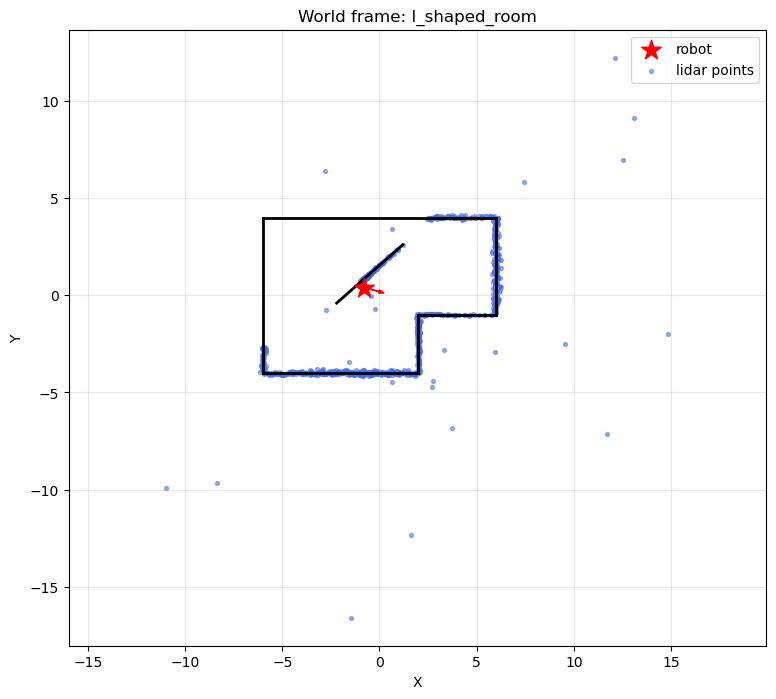

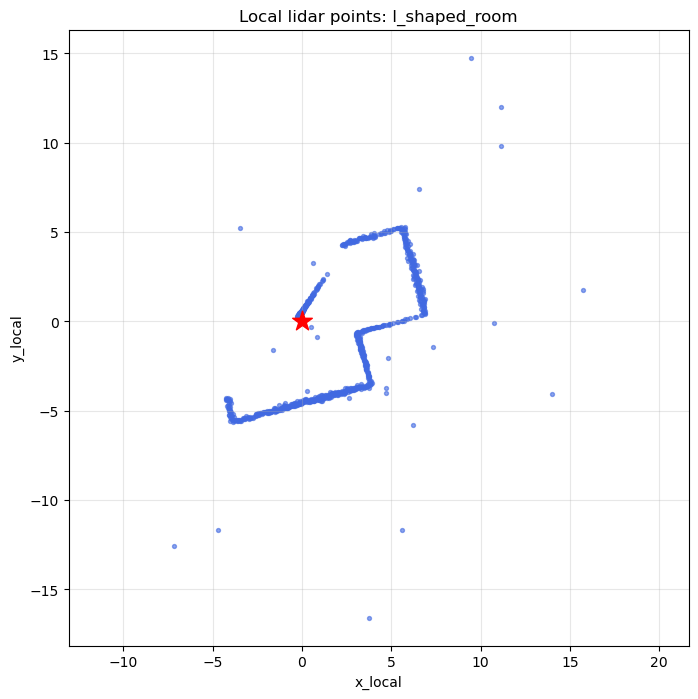

Detected lines: 6
 1. theta=146.00 deg | rho=  0.330 | votes=174
 2. theta=155.00 deg | rho=  0.280 | votes=98
 3. theta=105.00 deg | rho= -4.420 | votes=84
 4. theta=137.00 deg | rho=  0.380 | votes=77
 5. theta=167.00 deg | rho=  0.230 | votes=69
 6. theta=128.00 deg | rho=  0.380 | votes=58


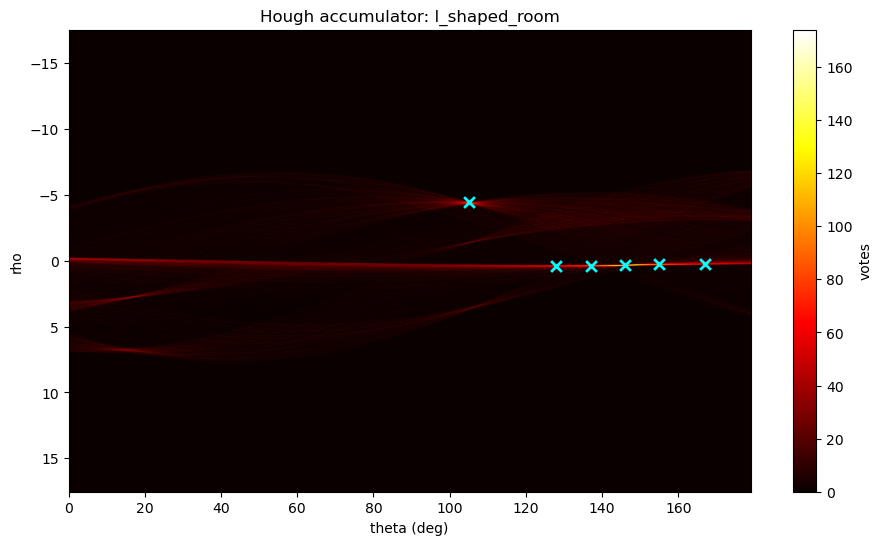

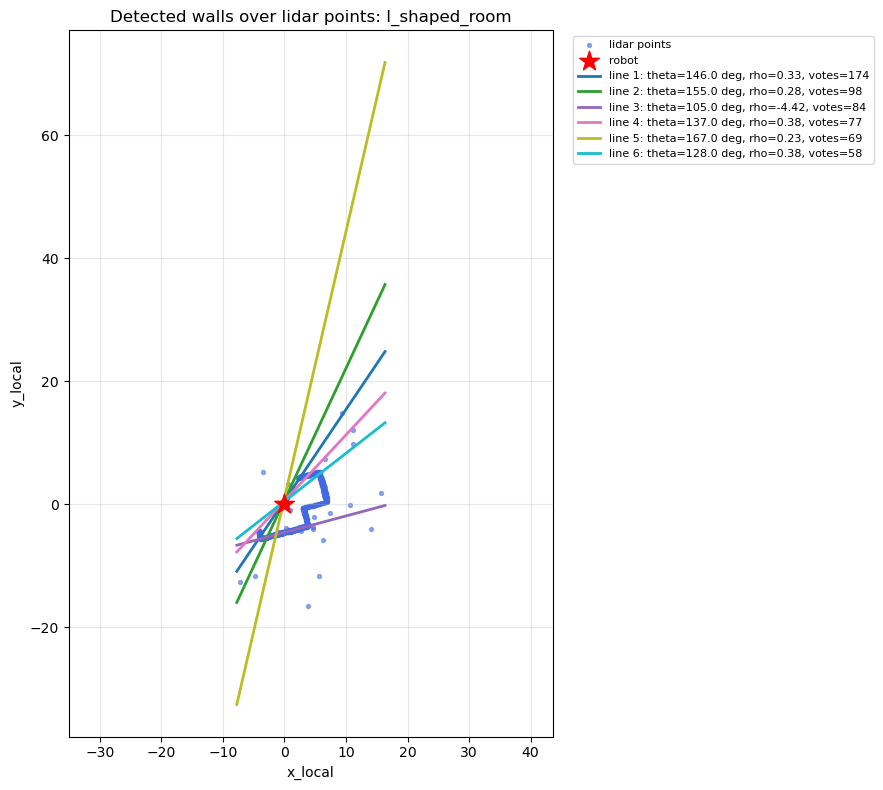

Scenario: irregular_with_angles
Lidar points: 944
Beam coverage (valid): 94.4%


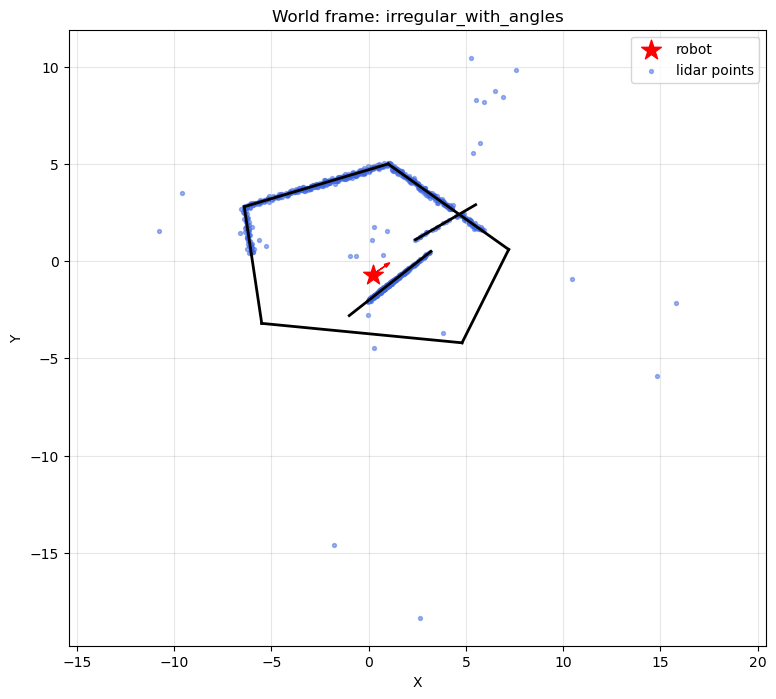

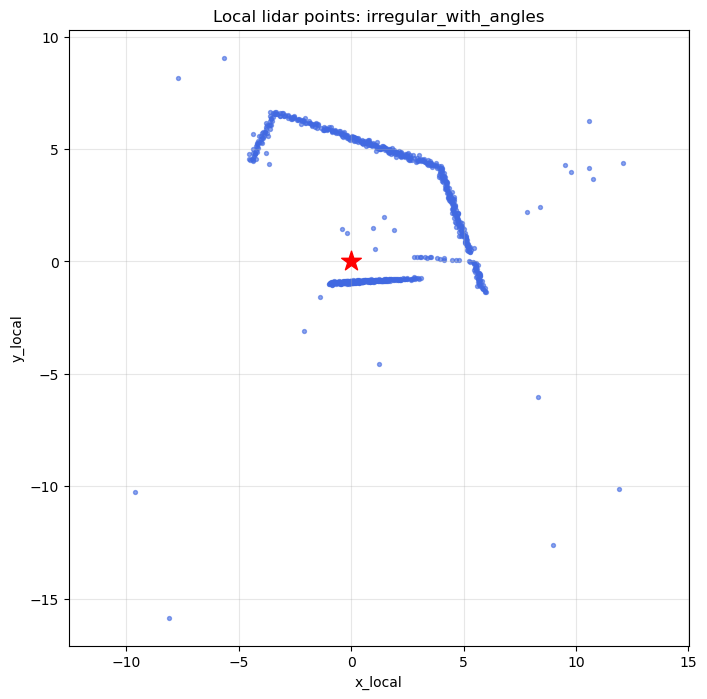

Detected lines: 1
 1. theta= 93.00 deg | rho= -0.906 | votes=265


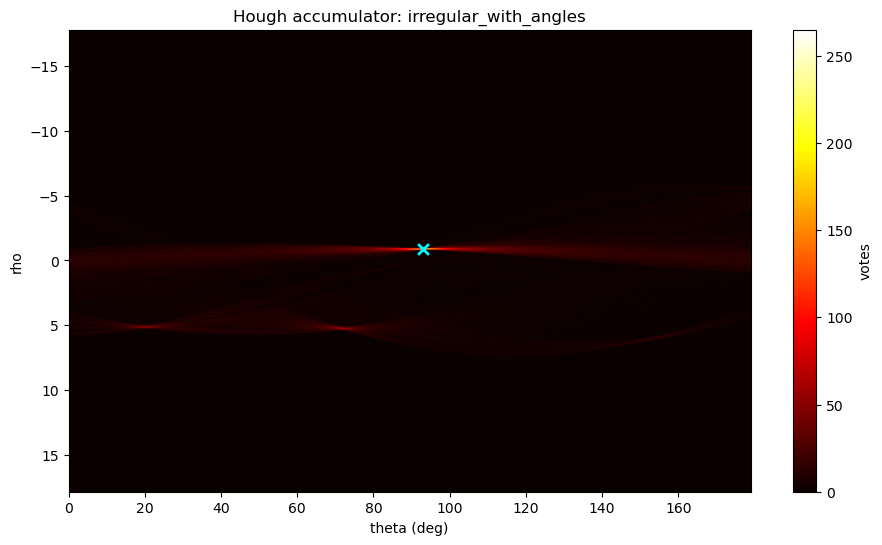

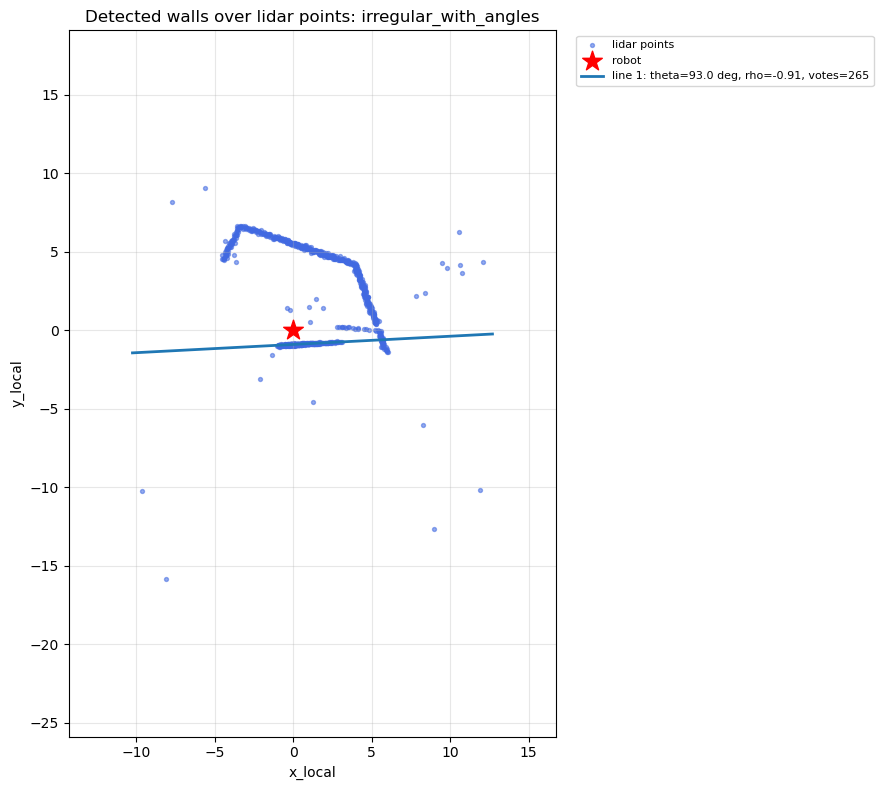

In [12]:
for scenario_name, cfg in scenarios.items():
    segments = cfg['segments']
    robot_pose = cfg['robot_pose']

    points_local, beam_angles, beam_ranges = simulate_lidar_scan(
        segments,
        robot_pose,
        num_beams=1000,
        fov_deg=270,
        range_max=18.0,
        range_noise_base=0.012,
        range_noise_scale=0.012,
        dropout_prob=0.06,
        outlier_prob=0.03,
        cartesian_jitter=0.02,
    )

    points_world = transform_to_world(points_local, robot_pose)

    print('Scenario:', scenario_name)
    print('Lidar points:', len(points_local))
    print('Beam coverage (valid):', f'{100.0 * len(points_local) / 1000:.1f}%')

    plot_scene_world(segments, robot_pose, points_world=points_world,
                    title=f'World frame: {scenario_name}')
    plot_scan_local(points_local, title=f'Local lidar points: {scenario_name}')

    peaks, accumulator, thetas, rhos = detect_walls_hough(
        points_local,
        theta_step_deg=1.0,
        rho_step=0.05,
        n_peaks=10,
        threshold_ratio=0.33,
        nms_rho=9,
        nms_theta=8,
    )

    print('Detected lines:', len(peaks))
    for i, (theta, rho, votes, _, _) in enumerate(peaks, 1):
        print(f'{i:2d}. theta={np.rad2deg(theta):6.2f} deg | rho={rho:7.3f} | votes={votes}')

    plot_hough_space(accumulator, thetas, rhos, peaks=peaks,
                    title=f'Hough accumulator: {scenario_name}')
    plot_detected_lines(points_local, peaks,
                        title=f'Detected walls over lidar points: {scenario_name}')


### `rect_plus_diagonal` scene:

* World plot shows two dominant structures in the returns: a dense **top horizontal wall band** and a clear **diagonal band**; other rectangle sides are weakly sampled (mostly short corner fragments + outliers).
* Hough accumulator contains **two clearly separated strong peaks**, matching those two structures (≈θ=120°, ρ≈−1.25, ~240 votes and ≈θ=70°, ρ≈4.20, ~98 votes).
* Detected-lines plot overlays **two lines**: one aligns with the diagonal return band; the other corresponds to the dominant wall direction and extends across the scan as an infinite line.

### `l_shaped_room` scene:

* World plot shows returns densely tracing the **L-shaped boundary**, with strongest coverage on the **top horizontal** and **right vertical** sections; a few far points appear as outliers.
* Hough accumulator shows **one distinct strong peak** (≈θ=105°, ρ≈−4.42) plus a **cluster of nearby peaks near ρ≈0** over θ≈128–167°, indicating several similar line hypotheses from partial segments + discretization.
* Detected-lines plot shows **multiple near-parallel lines** (a “fan”), i.e., duplicates/variants of the dominant wall orientation rather than one clean line per wall.

### `irregular_with_angles` scene:

* World plot indicates returns concentrated mainly on **two adjacent edges** (a turning corner), while other polygon sides have noticeably weaker point support.
* Hough accumulator is dominated by **one very strong peak** (≈θ=93°, ρ≈−0.91, ~265 votes); remaining wall directions stay below the selection threshold after NMS.
* Detected-lines plot draws **only one line**, matching the most supported edge direction; other walls are not output because their peaks are comparatively weak.


## Conclusion

Overall, the Hough pipeline consistently locks onto the **most dominant, best-sampled straight structures** in each scan (e.g., the diagonal in `rect_plus_diagonal`, the main edge in `irregular_with_angles`). In more complex geometry like `l_shaped_room`, **partial visibility + discretization** spreads votes across nearby bins, so a single physical wall can appear as **multiple similar peak lines**, while weaker walls may fall below the threshold. Performance and visual quality can be improved by adding **pre-filtering** (range gating, outlier removal, downsampling), **distance-to-line inlier checks** after peak selection, and **segment extraction/merging** to convert infinite Hough lines into wall-length line segments.
